01_task_NW_load_data.ipynb

02_task_NW_strategies.ipynb <<<<< we're here

03_task_NW_EDA.ipynb

04_task_NW_backtest.ipynb

------

In this file, we'll look at some basic trading strategies

------

To work properly with the data, we need more of it. Just one day of data isn't enough to split it into in-sample and out-of-sample parts and still get a reliable evaluation of results.

Because of that, everything in this script is not a fully fair experiment - we can't do a proper test where we train a strategy on one part of the data and test it on another.

It's important to note that each strategy shown here can be improved. For example, we could filter entry and exit points more carefully, add volatility checks, or other conditions. But in this script, we're keeping the strategies simple.

# init

In [ ]:
import numpy as np
import datetime
import pandas as pd
from numba import njit, prange
import pickle
import matplotlib.pyplot as plt

# load

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/data/test01/snapshots_D.pkl', 'rb') as file:
    snapshots_D = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/data/test01/snapshots_receive_ms_D.pkl', 'rb') as file:
    snapshots_receive_ms_D = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/data/test01/snapshots_server_ms_D.pkl', 'rb') as file:
    snapshots_server_ms_D = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/data/test01/trades_D.pkl', 'rb') as file:
    trades_D = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/data/test01/trades_receive_ms_D.pkl', 'rb') as file:
    trades_receive_ms_D = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/data/test01/trades_server_ms_D.pkl', 'rb') as file:
    trades_server_ms_D = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/data/test01/snapshots_B.pkl', 'rb') as file:
    snapshots_B = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/data/test01/snapshots_receive_ms_B.pkl', 'rb') as file:
    snapshots_receive_ms_B = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/data/test01/snapshots_server_ms_B.pkl', 'rb') as file:
    snapshots_server_ms_B = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/data/test01/trades_B.pkl', 'rb') as file:
    trades_B = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/data/test01/trades_receive_ms_B.pkl', 'rb') as file:
    trades_receive_ms_B = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/data/test01/trades_server_ms_B.pkl', 'rb') as file:
    trades_server_ms_B = pickle.load(file)

# Convert to 50 ms

For further analysis, high-frequency data will be grouped into 50ms intervals (20 points per second), as this provides a good balance between detail and data volume for our purposes

In [ ]:
#create 4 datasets
depth = 10
cols_snap = []
for side in ['ask', 'bid']:
    for feat in ['price', 'volume']:
        for lvl in range(depth):
            cols_snap.append(f'{side}_{feat}_{lvl}')

N_D, _, _, _ = snapshots_D.shape
flat_D = snapshots_D.reshape(N_D, -1).astype(np.float32)
df_snap_D = pd.DataFrame(flat_D, columns=cols_snap)
df_snap_D['receive_ms'] = snapshots_receive_ms_D
df_snap_D['server_ms'] = snapshots_server_ms_D
df_snap_D.set_index('receive_ms', inplace=True)

df_trades_D = pd.DataFrame(
    trades_D,
    columns=['side', 'price', 'volume']
)
df_trades_D = df_trades_D.astype({'price':'float32','volume':'float32'})
df_trades_D['side'] = df_trades_D['side'].map(lambda x: 1 if x == 1 else -1)
df_trades_D['is_buy']  = (df_trades_D['side'] > 0).astype('uint8')
df_trades_D['is_sell'] = (df_trades_D['side'] < 0).astype('uint8')
df_trades_D['buy_volume']  = df_trades_D['is_buy']  * df_trades_D['volume']
df_trades_D['sell_volume'] = df_trades_D['is_sell'] * df_trades_D['volume']
df_trades_D['receive_ms'] = trades_receive_ms_D
df_trades_D['server_ms'] = trades_server_ms_D
df_trades_D.set_index('receive_ms', inplace=True)

N_B, _, _, _ = snapshots_B.shape
flat_B = snapshots_B.reshape(N_B, -1).astype(np.float32)
df_snap_B = pd.DataFrame(flat_B, columns=cols_snap)
df_snap_B['receive_ms'] = snapshots_receive_ms_B
df_snap_B['server_ms'] = snapshots_server_ms_B
df_snap_B.set_index('receive_ms', inplace=True)

df_trades_B = pd.DataFrame(
    trades_B,
    columns=['side', 'price', 'volume']
)
df_trades_B = df_trades_B.astype({'price':'float32','volume':'float32'})
df_trades_B['side'] = df_trades_B['side'].map(lambda x: 1 if x == 1 else -1)
df_trades_B['is_buy']  = (df_trades_B['side'] > 0).astype('uint8')
df_trades_B['is_sell'] = (df_trades_B['side'] < 0).astype('uint8')
df_trades_B['buy_volume']  = df_trades_B['is_buy']  * df_trades_B['volume']
df_trades_B['sell_volume'] = df_trades_B['is_sell'] * df_trades_B['volume']
df_trades_B['receive_ms'] = trades_receive_ms_B
df_trades_B['server_ms'] = trades_server_ms_B
df_trades_B.set_index('receive_ms', inplace=True)

#prefixes
df_snap_D = df_snap_D.add_prefix("D_ob_")
df_trades_D = df_trades_D.add_prefix("D_tr_")

df_snap_B = df_snap_B.add_prefix("B_ob_")
df_trades_B = df_trades_B.add_prefix("B_tr_")

df_all = pd.concat([df_snap_D, df_trades_D, df_snap_B, df_trades_B])
df_all = df_all.sort_index().astype(np.float32)

#index
df_all['rms'] = df_all.index
df_all.index = pd.to_datetime(df_all.index, unit='us')


#calculate add/rem volume in first level
delta_ask = df_all['D_ob_ask_volume_0'] - df_all['D_ob_ask_volume_0'].shift(1)
delta_bid = df_all['D_ob_bid_volume_0'] - df_all['D_ob_bid_volume_0'].shift(1)

D_ask_v_add = delta_ask.clip(lower=0)
D_ask_v_rem = (-delta_ask.clip(upper=0))

D_bid_v_add = delta_bid.clip(lower=0)
D_bid_v_rem = (-delta_bid.clip(upper=0))

df_all['D_ob_ask_add_volume_0'] = D_ask_v_add.rolling('50ms').sum()
df_all['D_ob_ask_rem_volume_0'] = D_ask_v_rem.rolling('50ms').sum()
df_all['D_ob_bid_add_volume_0'] = D_bid_v_add.rolling('50ms').sum()
df_all['D_ob_bid_rem_volume_0'] = D_bid_v_rem.rolling('50ms').sum()


delta_ask = df_all['B_ob_ask_volume_0'] - df_all['B_ob_ask_volume_0'].shift(1)
delta_bid = df_all['B_ob_bid_volume_0'] - df_all['B_ob_bid_volume_0'].shift(1)

B_ask_v_add = delta_ask.clip(lower=0)
B_ask_v_rem = (-delta_ask.clip(upper=0))

B_bid_v_add = delta_bid.clip(lower=0)
B_bid_v_rem = (-delta_bid.clip(upper=0))

df_all['B_ob_ask_add_volume_0'] = B_ask_v_add.rolling('50ms').sum()
df_all['B_ob_ask_rem_volume_0'] = B_ask_v_rem.rolling('50ms').sum()
df_all['B_ob_bid_add_volume_0'] = B_bid_v_add.rolling('50ms').sum()
df_all['B_ob_bid_rem_volume_0'] = B_bid_v_rem.rolling('50ms').sum()

In [ ]:
steps_per_second = 20
ts_window = f'{1000/steps_per_second}ms'

df0 = df_all.resample(ts_window).mean()

b_count = df_all['B_tr_price'].resample(ts_window).count().rename('B_tr_count')
d_count = df_all['D_tr_price'].resample(ts_window).count().rename('D_tr_count')

df0 = (
    df0
    .join([b_count, d_count])
    .fillna({'B_tr_count': 0, 'D_tr_count': 0})
)

df0['B_tr_buy_count'] = (df0['B_tr_is_buy']*df0['B_tr_count']).abs()
df0['B_tr_sell_count'] = (df0['B_tr_is_sell']*df0['B_tr_count']).abs()
df0['D_tr_buy_count'] = (df0['D_tr_is_buy']*df0['D_tr_count']).abs()
df0['D_tr_sell_count'] = (df0['D_tr_is_sell']*df0['D_tr_count']).abs()

new_index = pd.date_range(start=pd.Timestamp('2023-01-30 00:00:00'), end=pd.Timestamp('2023-01-30 23:59:59.950000'), freq='50ms')

df0 = df0.reindex(new_index)


cols_B_ob = df0.filter(like='B_ob_').columns
cols_D_ob = df0.filter(like='D_ob_').columns

df0[cols_B_ob] = df0[cols_B_ob].ffill()
df0[cols_D_ob] = df0[cols_D_ob].ffill()

df0.shape

(1728000, 113)

# CONST

Init const

In [103]:
MAX_POSITION = 1_000_000

D_fee = 0.010/100
B_fee = 0.005/100

D_fee_ = 0.050/100
B_fee_ = 0.0175/100

# FUNCS

simple function for calculation pnl

In [ ]:
def calc_r(side, amount, price, fee):
    return amount/price*(side - fee)

check it (compare with binance calculate)

In [494]:
RS, RE = 0, 0
RE += calc_r(-1, MAX_POSITION/10, 23800, 0/100)
RE += calc_r(+1, MAX_POSITION/10, 22800, 0/100)
print(f"{RS:.4f} > {RE:.4f}")

0.0000 > 0.1843


# BUY/SELL in START/END

In [ ]:
df = df0.copy()

## long position

In [ ]:
D_RS, D_RE, B_RS, B_RE = 0, 0, 0, 0
D_price_start = df['D_ob_ask_price_0'].iloc[:100000].mean()
B_price_start = df['B_ob_ask_price_0'].iloc[:100000].mean()

D_price_end = df['D_ob_bid_price_0'].iloc[-100000:].mean()
B_price_end = df['B_ob_bid_price_0'].iloc[-100000:].mean()

D_RE += calc_r(+1, MAX_POSITION, D_price_start, D_fee)
B_RE += calc_r(+1, MAX_POSITION, B_price_start, B_fee)

D_RE += calc_r(-1, MAX_POSITION, D_price_end, D_fee)
B_RE += calc_r(-1, MAX_POSITION, B_price_end, B_fee)

print(f"D={D_RE:.4f}, B={B_RE:.4f}, total={D_RE+B_RE:.4f}")

D=-1.8405, B=-1.8515, total=-3.6920


## short position

In [ ]:
D_RS, D_RE, B_RS, B_RE = 0, 0, 0, 0
D_price_start = df['D_ob_bid_price_0'].iloc[:100000].mean()
B_price_start = df['B_ob_bid_price_0'].iloc[:100000].mean()

D_price_end = df['D_ob_ask_price_0'].iloc[-100000:].mean()
B_price_end = df['B_ob_ask_price_0'].iloc[-100000:].mean()

D_RE += calc_r(-1, MAX_POSITION, D_price_start, D_fee)
B_RE += calc_r(-1, MAX_POSITION, B_price_start, B_fee)

D_RE += calc_r(+1, MAX_POSITION, D_price_end, D_fee)
B_RE += calc_r(+1, MAX_POSITION, B_price_end, B_fee)

print(f"D={D_RE:.4f}, B={B_RE:.4f}, total={D_RE+B_RE:.4f}")

D=1.8213, B=1.8408, total=3.6621


We used TWAP to enter and exit positions.

The problem is that the full amount at risk is 2 * MAX_POSITION (since we open positions on both exchanges).

Of course, we can't predict the price movement for the whole day in advance, so in reality, this is more like playing roulette.

# ROLLINGS

The idea behind these types of strategies is to tolerate many small losses in order to catch one big move.

We'll try some simple strategies where entry points are based on moving averages.

Unfortunately, one day of data is far too little to properly test the robustness of any algorithm.

To keep things somewhat fair, we'll split the data into two parts (train/test). We'll tune the parameters on the train set and test the results on the test set.

## single SMA

Hypothesis: if the price is below the N-period moving average, we go short. If it’s above, we go long.

For simplicity, we’ll use only one exchange (Bitmex), since it has lower fees.

In [ ]:
df = df0[2000:-2000].copy()
df['B_ask'] = df['B_ob_ask_price_0']
df['B_bid'] = df['B_ob_bid_price_0']
df['B_mid'] = (df['B_ask'] + df['B_bid'])/2

#for not looking future - shift
df['SMA_1min'] = df['B_mid'].rolling('1min').mean().shift(1)

In [ ]:
train = df[:int(len(df)/2)]
test = df[int(len(df)/2):]

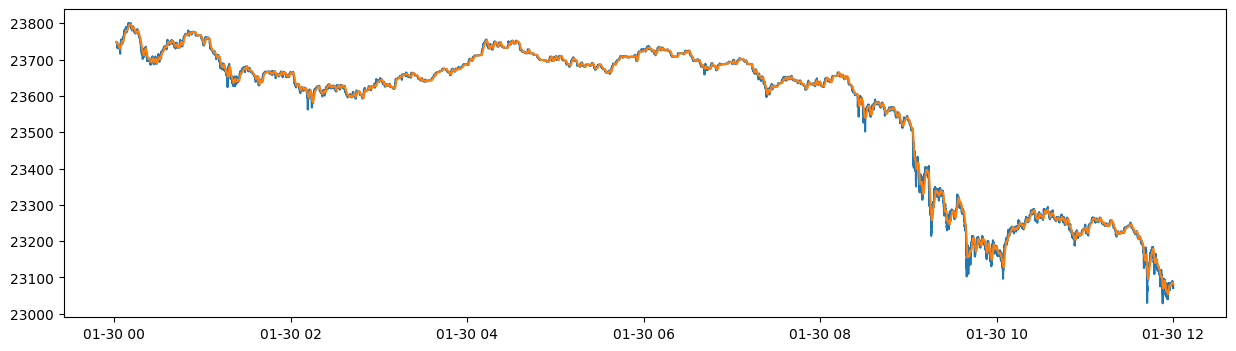

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(train['B_ask'])
plt.plot(train['SMA_1min'])
plt.show()

### train

In [ ]:
B_RS, B_RE = 0, 0

th = 5
status = 0

pnls = []
positions = []

for i, row in train.iterrows():
    p = row['B_mid']
    s = row['SMA_1min']

    #long
    if p > s + th and status == 0:
        status = 1
        B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
        position = {
            'i_open':i,
            'side':+1,
            'p_open':row['B_ask']
        }
    elif p < s and status == 1:
        status = 0
        B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
        position['i_exit'] = i
        position['p_exit'] = row['B_bid']
        position['p_delta'] = position['p_exit'] - position['p_open']
        position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit']) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
        positions.append(position)

    #short
    elif p < s - th and status == 0:
        status = -1
        B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
        position = {
            'i_open':i,
            'side':-1,
            'p_open':row['B_bid']
        }
    elif p > s and status == -1:
        status = 0
        B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
        position['i_exit'] = i
        position['p_exit'] = row['B_ask']
        position['p_delta'] = position['p_exit'] - position['p_open']
        position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit'])*(-1) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
        positions.append(position)

    if status == 0:
        pnls.append(B_RE)

#close position, if open
if status == 1:
    B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
    position['i_exit'] = i
    position['p_exit'] = row['B_bid']
    position['p_delta'] = position['p_exit'] - position['p_open']
    position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit']) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
    positions.append(position)
if status == -1:
    B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
    position['i_exit'] = i
    position['p_exit'] = row['B_ask']
    position['p_delta'] = position['p_exit'] - position['p_open']
    position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit'])*(-1) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
    positions.append(position)

print(f"{B_RS:.4f} > {B_RE:.4f}")

0.0000 > 1.6991


1.6991478070287895


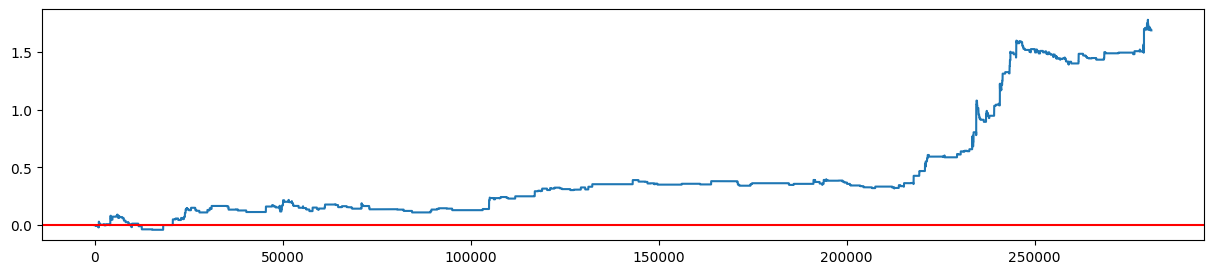

In [ ]:
print(pd.DataFrame(positions)['pnl'].sum())
plt.figure(figsize=(15,3))
plt.plot(pnls)
plt.axhline(0, color='r')
plt.show()

### test

In [ ]:
B_RS, B_RE = 0, 0

th = 5
status = 0

pnls = []
positions = []

for i, row in test.iterrows():
    p = row['B_mid']
    s = row['SMA_1min']

    #long
    if p > s + th and status == 0:
        status = 1
        B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
        position = {
            'i_open':i,
            'side':+1,
            'p_open':row['B_ask']
        }
    elif p < s and status == 1:
        status = 0
        B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
        position['i_exit'] = i
        position['p_exit'] = row['B_bid']
        position['p_delta'] = position['p_exit'] - position['p_open']
        position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit']) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
        positions.append(position)

    #short
    elif p < s - th and status == 0:
        status = -1
        B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
        position = {
            'i_open':i,
            'side':-1,
            'p_open':row['B_bid']
        }
    elif p > s and status == -1:
        status = 0
        B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
        position['i_exit'] = i
        position['p_exit'] = row['B_ask']
        position['p_delta'] = position['p_exit'] - position['p_open']
        position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit'])*(-1) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
        positions.append(position)

    if status == 0:
        pnls.append(B_RE)

#close position, if open
if status == 1:
    B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
    position['i_exit'] = i
    position['p_exit'] = row['B_bid']
    position['p_delta'] = position['p_exit'] - position['p_open']
    position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit']) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
    positions.append(position)
if status == -1:
    B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
    position['i_exit'] = i
    position['p_exit'] = row['B_ask']
    position['p_delta'] = position['p_exit'] - position['p_open']
    position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit'])*(-1) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
    positions.append(position)

print(f"{B_RS:.4f} > {B_RE:.4f}")

0.0000 > 2.7970


2.797002239389446


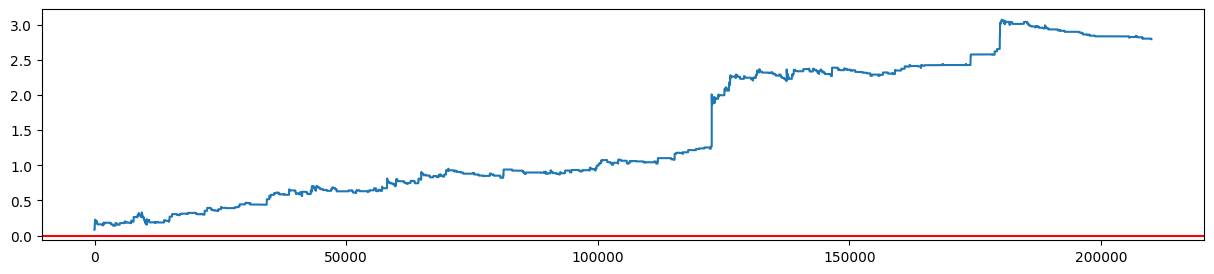

In [ ]:
print(pd.DataFrame(positions)['pnl'].sum())
plt.figure(figsize=(15,3))
plt.plot(pnls)
plt.axhline(0, color='r')
plt.show()

However, even though the current strategy showed a decent result, we need to keep in mind that it should be tested on a larger number of days - ideally, at least a year.

### test with large fee

In [104]:
B_RS, B_RE = 0, 0

th = 5
status = 0

pnls = []
positions = []

for i, row in test.iterrows():
    p = row['B_mid']
    s = row['SMA_1min']

    #long
    if p > s + th and status == 0:
        status = 1
        B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee_)
        position = {
            'i_open':i,
            'side':+1,
            'p_open':row['B_ask']
        }
    elif p < s and status == 1:
        status = 0
        B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee_)
        position['i_exit'] = i
        position['p_exit'] = row['B_bid']
        position['p_delta'] = position['p_exit'] - position['p_open']
        position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit']) - MAX_POSITION/position['p_open']*B_fee_ - MAX_POSITION/position['p_exit']*B_fee_
        positions.append(position)

    #short
    elif p < s - th and status == 0:
        status = -1
        B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee_)
        position = {
            'i_open':i,
            'side':-1,
            'p_open':row['B_bid']
        }
    elif p > s and status == -1:
        status = 0
        B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee_)
        position['i_exit'] = i
        position['p_exit'] = row['B_ask']
        position['p_delta'] = position['p_exit'] - position['p_open']
        position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit'])*(-1) - MAX_POSITION/position['p_open']*B_fee_ - MAX_POSITION/position['p_exit']*B_fee_
        positions.append(position)

    if status == 0:
        pnls.append(B_RE)

#close position, if open
if status == 1:
    B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee_)
    position['i_exit'] = i
    position['p_exit'] = row['B_bid']
    position['p_delta'] = position['p_exit'] - position['p_open']
    position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit']) - MAX_POSITION/position['p_open']*B_fee_ - MAX_POSITION/position['p_exit']*B_fee_
    positions.append(position)
if status == -1:
    B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee_)
    position['i_exit'] = i
    position['p_exit'] = row['B_ask']
    position['p_delta'] = position['p_exit'] - position['p_open']
    position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit'])*(-1) - MAX_POSITION/position['p_open']*B_fee_ - MAX_POSITION/position['p_exit']*B_fee_
    positions.append(position)

print(f"{B_RS:.4f} > {B_RE:.4f}")

0.0000 > -4.0640


-4.063994606783803


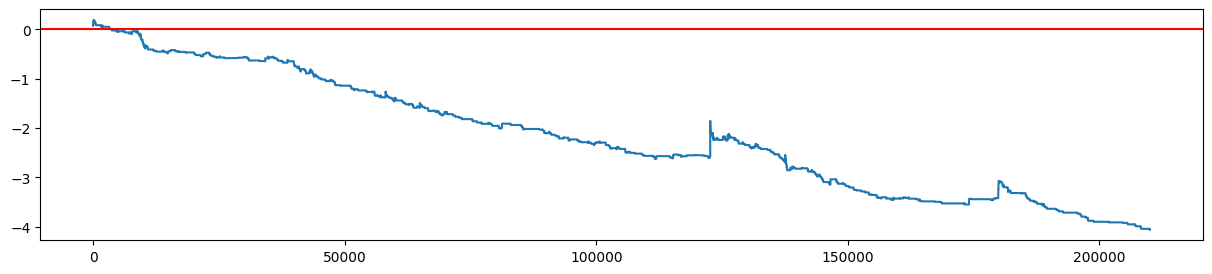

In [105]:
print(pd.DataFrame(positions)['pnl'].sum())
plt.figure(figsize=(15,3))
plt.plot(pnls)
plt.axhline(0, color='r')
plt.show()

When we increase the fee, the results get much worse. Of course, we could try to tweak the smoothing and entry threshold to get a positive result on this dataset - but that doesn't guarantee it will work on future data

## double EWM

In [167]:
df = df0[2000:-2000].copy()
df['B_ask'] = df['B_ob_ask_price_0']
df['B_bid'] = df['B_ob_bid_price_0']
df['B_mid'] = (df['B_ask'] + df['B_bid'])/2

#for not looking future - shift

train = df[:int(len(df)/2)][['B_ask','B_bid','B_mid']].copy()
train['EWM_fast'] = train['B_mid'].ewm(span=20*60*5).mean().shift(1)
train['EWM_slow'] = train['B_mid'].ewm(span=20*60*60).mean().shift(1)

test = df[int(len(df)/2):][['B_ask','B_bid','B_mid']].copy()
test['EWM_fast'] = test['B_mid'].ewm(span=20*60*5).mean().shift(1)
test['EWM_slow'] = test['B_mid'].ewm(span=20*60*60).mean().shift(1)

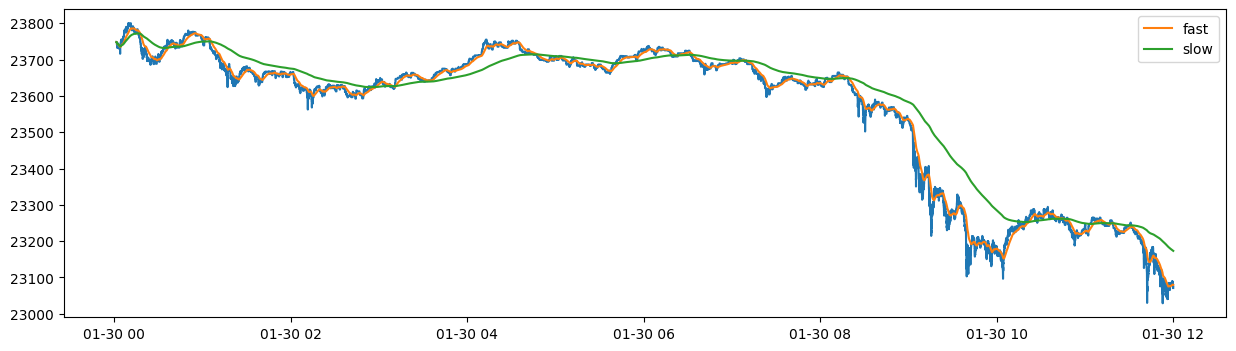

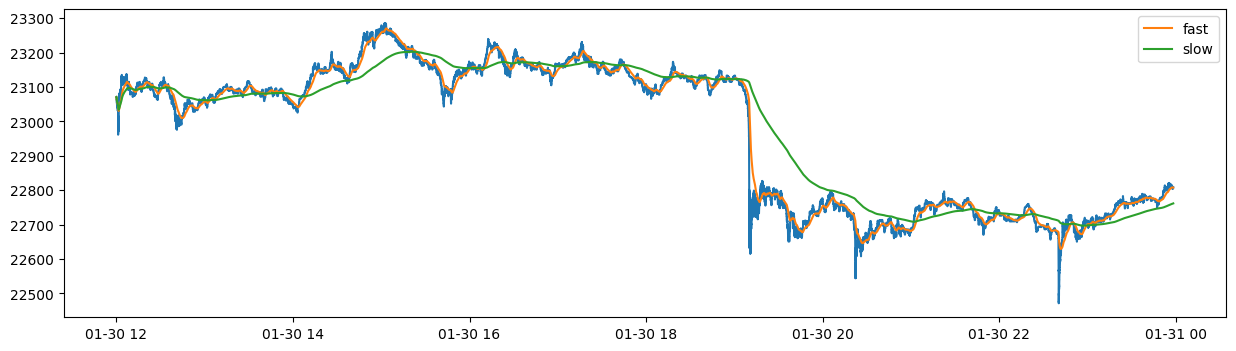

In [168]:
temp = train[:]
plt.figure(figsize=(15,4))
plt.plot(temp['B_ask'])
plt.plot(temp['EWM_fast'], label='fast')
plt.plot(temp['EWM_slow'], label='slow')
plt.legend()
plt.show()

temp = test[:]
plt.figure(figsize=(15,4))
plt.plot(temp['B_ask'])
plt.plot(temp['EWM_fast'], label='fast')
plt.plot(temp['EWM_slow'], label='slow')
plt.legend()
plt.show()

### train

In [169]:
B_RS, B_RE = 0, 0

th = 0.1
status = 0

pnls = []
positions = []

for i, row in train.iterrows():
    p = row['B_mid']
    f = row['EWM_fast']
    s = row['EWM_slow']

    #long
    if f > s + th and status == 0:
        status = 1
        B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
        position = {
            'i_open':i,
            'side':+1,
            'p_open':row['B_ask']
        }
    elif f < s and status == 1:
        status = 0
        B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
        position['i_exit'] = i
        position['p_exit'] = row['B_bid']
        position['p_delta'] = position['p_exit'] - position['p_open']
        position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit']) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
        positions.append(position)

    #short
    elif f < s - th and status == 0:
        status = -1
        B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
        position = {
            'i_open':i,
            'side':-1,
            'p_open':row['B_bid']
        }
    elif f > s and status == -1:
        status = 0
        B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
        position['i_exit'] = i
        position['p_exit'] = row['B_ask']
        position['p_delta'] = position['p_exit'] - position['p_open']
        position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit'])*(-1) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
        positions.append(position)

    if status == 0:
        pnls.append(B_RE)

#close position, if open
if status == 1:
    B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
    position['i_exit'] = i
    position['p_exit'] = row['B_bid']
    position['p_delta'] = position['p_exit'] - position['p_open']
    position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit']) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
    positions.append(position)
if status == -1:
    B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
    position['i_exit'] = i
    position['p_exit'] = row['B_ask']
    position['p_delta'] = position['p_exit'] - position['p_open']
    position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit'])*(-1) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
    positions.append(position)

print(f"{B_RS:.4f} > {B_RE:.4f}")

0.0000 > 0.8550


0.8550076867046553


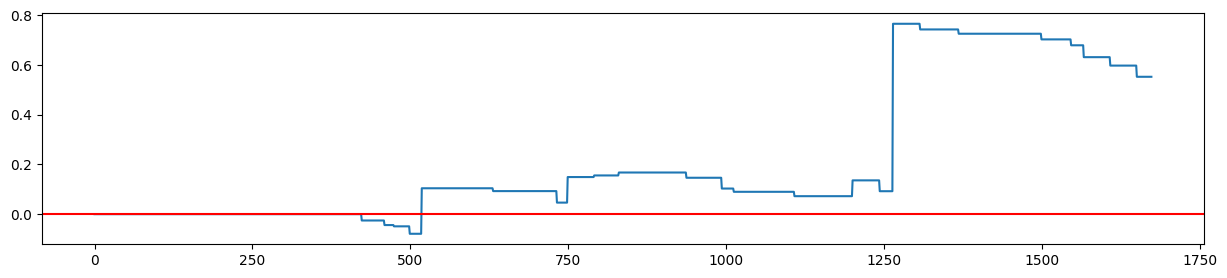

In [170]:
print(pd.DataFrame(positions)['pnl'].sum())
plt.figure(figsize=(15,3))
plt.plot(pnls)
plt.axhline(0, color='r')
plt.show()

### test

In [172]:
B_RS, B_RE = 0, 0

th = 0.1
status = 0

pnls = []
positions = []

for i, row in test.iterrows():
    p = row['B_mid']
    f = row['EWM_fast']
    s = row['EWM_slow']

    #long
    if f > s + th and status == 0:
        status = 1
        B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
        position = {
            'i_open':i,
            'side':+1,
            'p_open':row['B_ask']
        }
    elif f < s and status == 1:
        status = 0
        B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
        position['i_exit'] = i
        position['p_exit'] = row['B_bid']
        position['p_delta'] = position['p_exit'] - position['p_open']
        position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit']) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
        positions.append(position)

    #short
    elif f < s - th and status == 0:
        status = -1
        B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
        position = {
            'i_open':i,
            'side':-1,
            'p_open':row['B_bid']
        }
    elif f > s and status == -1:
        status = 0
        B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
        position['i_exit'] = i
        position['p_exit'] = row['B_ask']
        position['p_delta'] = position['p_exit'] - position['p_open']
        position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit'])*(-1) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
        positions.append(position)

    if status == 0:
        pnls.append(B_RE)

#close position, if open
if status == 1:
    B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
    position['i_exit'] = i
    position['p_exit'] = row['B_bid']
    position['p_delta'] = position['p_exit'] - position['p_open']
    position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit']) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
    positions.append(position)
if status == -1:
    B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
    position['i_exit'] = i
    position['p_exit'] = row['B_ask']
    position['p_delta'] = position['p_exit'] - position['p_open']
    position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit'])*(-1) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
    positions.append(position)

pnls.append(B_RE)

print(f"{B_RS:.4f} > {B_RE:.4f}")

0.0000 > -0.8201


-0.8201308083781466


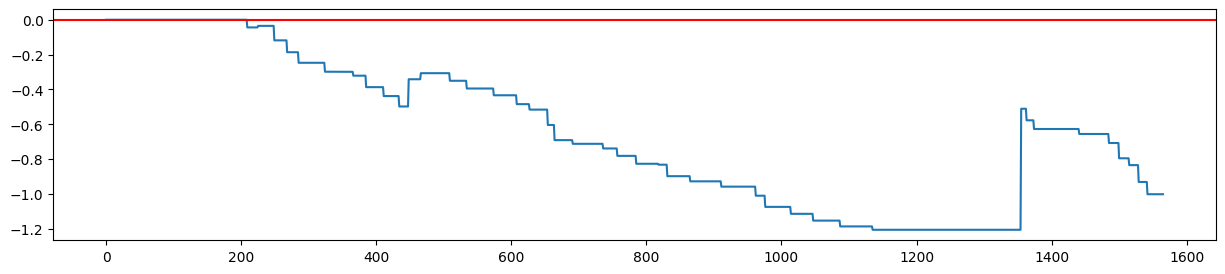

In [173]:
print(pd.DataFrame(positions)['pnl'].sum())
plt.figure(figsize=(15,3))
plt.plot(pnls)
plt.axhline(0, color='r')
plt.show()

Because of many small moves in the second half of the day, we enter and exit positions frequently, which eats up capital through fees.

It might make sense to try using KAMA (Kaufman's Adaptive Moving Average), which adjusts to the current level of volatility.

## KAMA

In [180]:
@njit
def kama_numba(price: np.ndarray,
               er_period: int,
               fast_period: int = 2,
               slow_period: int = 30) -> np.ndarray:
    n = price.shape[0]
    kama = np.empty(n, dtype=np.float64)
    change = np.zeros(n, dtype=np.float64)
    volatility = np.zeros(n, dtype=np.float64)
    er = np.zeros(n, dtype=np.float64)
    sc = np.zeros(n, dtype=np.float64)

    fast_sc = 2.0 / (fast_period + 1)
    slow_sc = 2.0 / (slow_period + 1)

    #calc er and adotrive const
    for i in range(er_period, n):
        change[i] = abs(price[i] - price[i - er_period])
        vol_sum = 0.0
        #sum abs in window
        for j in range(i - er_period + 1, i + 1):
            vol_sum += abs(price[j] - price[j - 1])
        volatility[i] = vol_sum

        er[i] = change[i] / volatility[i] if volatility[i] != 0 else 0.0
        sc[i] = (er[i] * (fast_sc - slow_sc) + slow_sc) ** 2

    #init
    kama[:er_period] = price[:er_period]
    kama[er_period] = price[er_period]

    #step by step
    for i in range(er_period + 1, n):
        kama[i] = kama[i - 1] + sc[i] * (price[i] - kama[i - 1])

    return kama

In [194]:
df = df0[2000:-2000].copy()
df['B_ask'] = df['B_ob_ask_price_0']
df['B_bid'] = df['B_ob_bid_price_0']
df['B_mid'] = (df['B_ask'] + df['B_bid'])/2

#for not looking future - shift

train = df[:int(len(df)/2)][['B_ask','B_bid','B_mid']].copy()
test = df[int(len(df)/2):][['B_ask','B_bid','B_mid']].copy()

fast_er = 20*60*5
slow_er = 20*60*60

prices_train = train['B_mid'].values
prices_test  = test['B_mid'].values

kama_fast_train = kama_numba(prices_train, er_period=fast_er, fast_period=50, slow_period=1000)
kama_slow_train = kama_numba(prices_train, er_period=slow_er, fast_period=50, slow_period=1000)

kama_fast_test = kama_numba(prices_test, er_period=fast_er, fast_period=50, slow_period=1000)
kama_slow_test = kama_numba(prices_test, er_period=slow_er, fast_period=50, slow_period=1000)

#with shift for not looking future
train['KAMA_fast'] = pd.Series(kama_fast_train, index=train.index).shift(1)
train['KAMA_slow'] = pd.Series(kama_slow_train, index=train.index).shift(1)
test['KAMA_fast']  = pd.Series(kama_fast_test,  index=test.index).shift(1)
test['KAMA_slow']  = pd.Series(kama_slow_test,  index=test.index).shift(1)

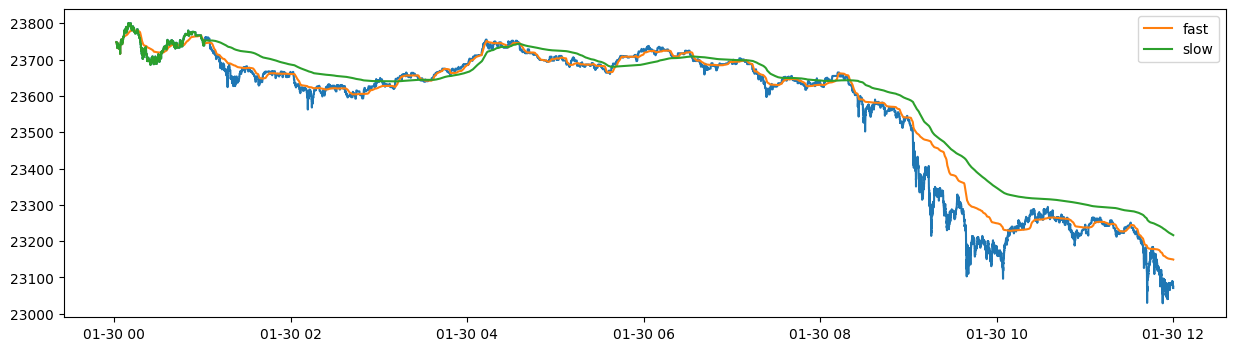

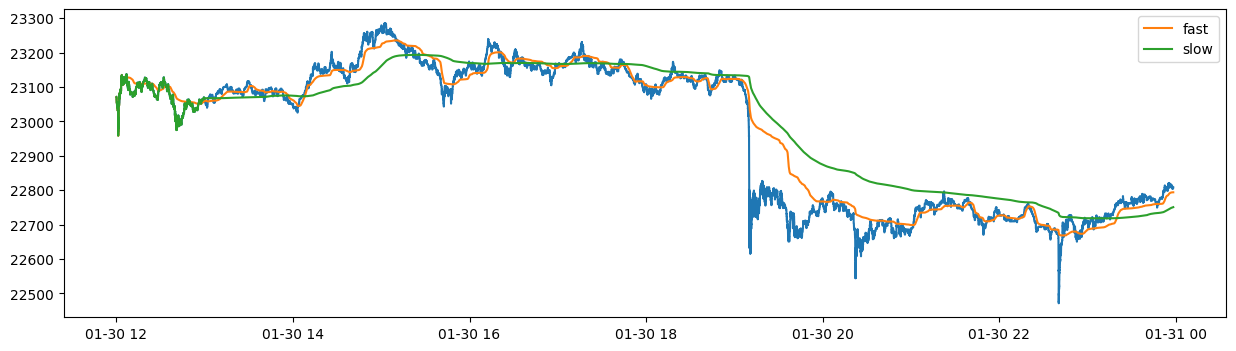

In [195]:
temp = train[:]
plt.figure(figsize=(15,4))
plt.plot(temp['B_ask'])
plt.plot(temp['KAMA_fast'], label='fast')
plt.plot(temp['KAMA_slow'], label='slow')
plt.legend()
plt.show()

temp = test[:]
plt.figure(figsize=(15,4))
plt.plot(temp['B_ask'])
plt.plot(temp['KAMA_fast'], label='fast')
plt.plot(temp['KAMA_slow'], label='slow')
plt.legend()
plt.show()

### train

In [198]:
B_RS, B_RE = 0, 0

th = 0.1
status = 0

pnls = []
pnls.append(B_RE)

positions = []

for i, row in train[slow_er:].iterrows():
    p = row['B_mid']
    f = row['KAMA_fast']
    s = row['KAMA_slow']

    #long
    if f > s + th and status == 0:
        status = 1
        B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
        position = {
            'i_open':i,
            'side':+1,
            'p_open':row['B_ask']
        }
    elif f < s and status == 1:
        status = 0
        B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
        position['i_exit'] = i
        position['p_exit'] = row['B_bid']
        position['p_delta'] = position['p_exit'] - position['p_open']
        position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit']) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
        positions.append(position)

    #short
    elif f < s - th and status == 0:
        status = -1
        B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
        position = {
            'i_open':i,
            'side':-1,
            'p_open':row['B_bid']
        }
    elif f > s and status == -1:
        status = 0
        B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
        position['i_exit'] = i
        position['p_exit'] = row['B_ask']
        position['p_delta'] = position['p_exit'] - position['p_open']
        position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit'])*(-1) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
        positions.append(position)

    if status == 0:
        pnls.append(B_RE)

#close position, if open
if status == 1:
    B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
    position['i_exit'] = i
    position['p_exit'] = row['B_bid']
    position['p_delta'] = position['p_exit'] - position['p_open']
    position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit']) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
    positions.append(position)
if status == -1:
    B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
    position['i_exit'] = i
    position['p_exit'] = row['B_ask']
    position['p_delta'] = position['p_exit'] - position['p_open']
    position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit'])*(-1) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
    positions.append(position)

pnls.append(B_RE)

print(f"{B_RS:.4f} > {B_RE:.4f}")

0.0000 > 1.3252


1.3252166249214017


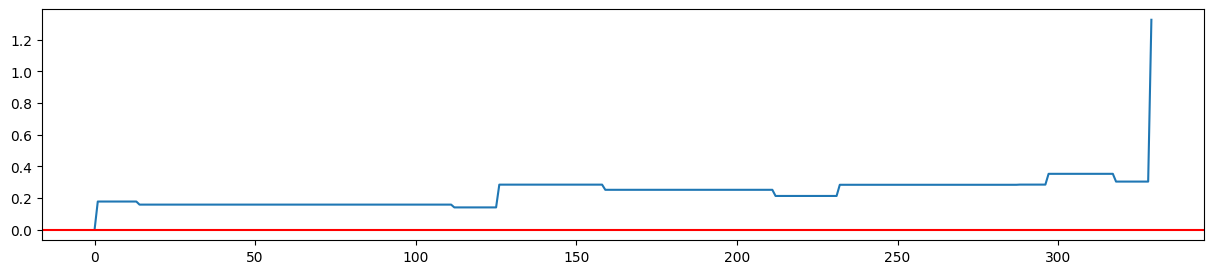

In [199]:
print(pd.DataFrame(positions)['pnl'].sum())
plt.figure(figsize=(15,3))
plt.plot(pnls)
plt.axhline(0, color='r')
plt.show()

### test

In [200]:
B_RS, B_RE = 0, 0

th = 0.1
status = 0

pnls = []
pnls.append(B_RE)

positions = []

for i, row in test[slow_er:].iterrows():
    p = row['B_mid']
    f = row['KAMA_fast']
    s = row['KAMA_slow']

    #long
    if f > s + th and status == 0:
        status = 1
        B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
        position = {
            'i_open':i,
            'side':+1,
            'p_open':row['B_ask']
        }
    elif f < s and status == 1:
        status = 0
        B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
        position['i_exit'] = i
        position['p_exit'] = row['B_bid']
        position['p_delta'] = position['p_exit'] - position['p_open']
        position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit']) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
        positions.append(position)

    #short
    elif f < s - th and status == 0:
        status = -1
        B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
        position = {
            'i_open':i,
            'side':-1,
            'p_open':row['B_bid']
        }
    elif f > s and status == -1:
        status = 0
        B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
        position['i_exit'] = i
        position['p_exit'] = row['B_ask']
        position['p_delta'] = position['p_exit'] - position['p_open']
        position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit'])*(-1) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
        positions.append(position)

    if status == 0:
        pnls.append(B_RE)

#close position, if open
if status == 1:
    B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
    position['i_exit'] = i
    position['p_exit'] = row['B_bid']
    position['p_delta'] = position['p_exit'] - position['p_open']
    position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit']) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
    positions.append(position)
if status == -1:
    B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
    position['i_exit'] = i
    position['p_exit'] = row['B_ask']
    position['p_delta'] = position['p_exit'] - position['p_open']
    position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit'])*(-1) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
    positions.append(position)

pnls.append(B_RE)

print(f"{B_RS:.4f} > {B_RE:.4f}")

0.0000 > 0.2933


0.29329281458037365


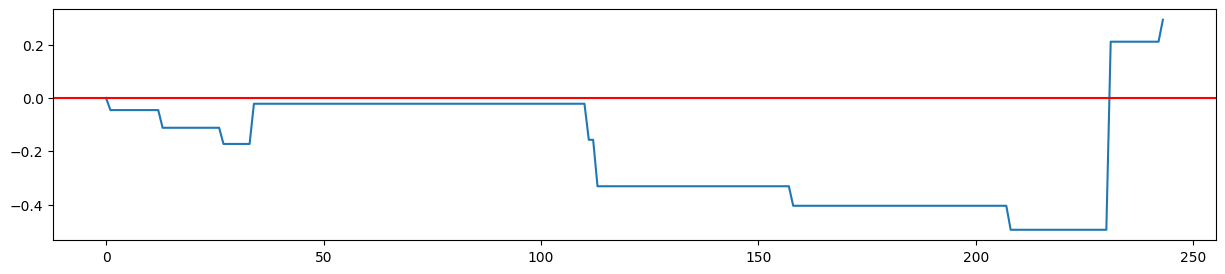

In [201]:
print(pd.DataFrame(positions)['pnl'].sum())
plt.figure(figsize=(15,3))
plt.plot(pnls)
plt.axhline(0, color='r')
plt.show()

# TRIX-momentum

In [202]:
def trix(price, period):
    ema1 = price.ewm(span=period, adjust=False).mean()
    ema2 = ema1.ewm(span=period, adjust=False).mean()
    ema3 = ema2.ewm(span=period, adjust=False).mean()
    trix = ema3.pct_change() * 100
    return trix

In [254]:
df = df0[2000:-2000].copy()
df['B_ask'] = df['B_ob_ask_price_0']
df['B_bid'] = df['B_ob_bid_price_0']
df['B_mid'] = (df['B_ask'] + df['B_bid'])/2

train = df[:int(len(df)/2)][['B_ask','B_bid','B_mid']].copy()
test = df[int(len(df)/2):][['B_ask','B_bid','B_mid']].copy()

period = 20*60*30
train['TRIX'] = trix(train['B_mid'], period).shift(1)
test['TRIX'] = trix(test ['B_mid'], period).shift(1)

train['TRIX_diff'] = train['TRIX'].rolling(50000).mean().diff()
test['TRIX_diff'] = test['TRIX'].rolling(50000).mean().diff()

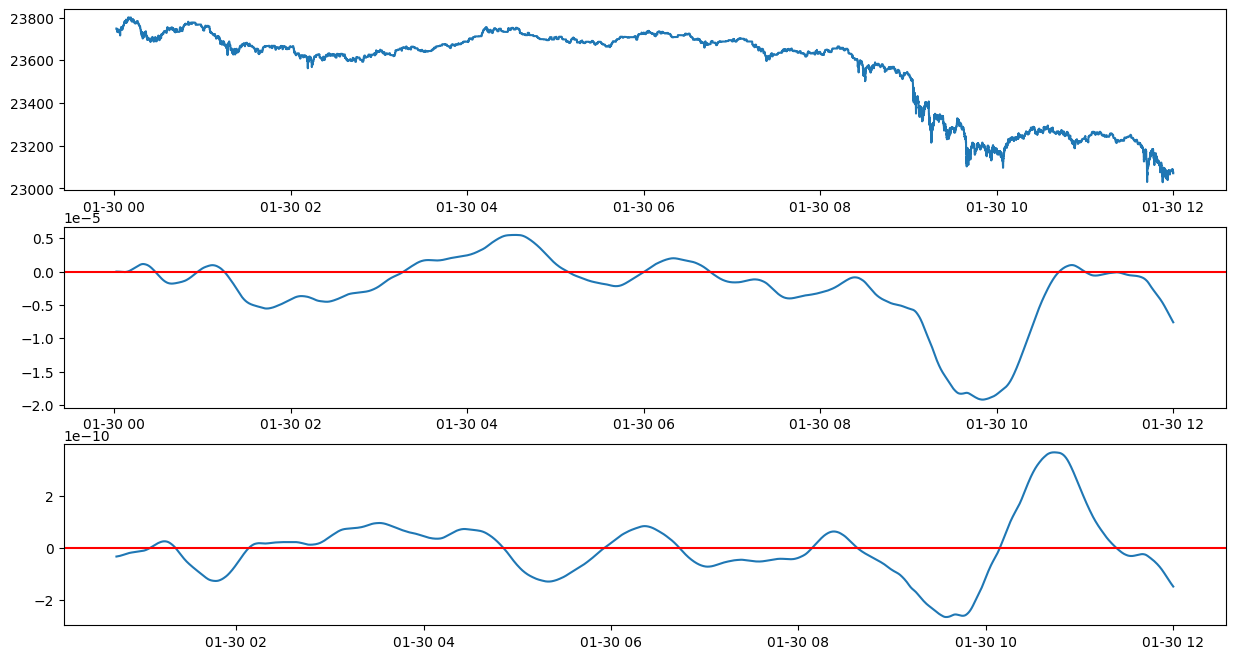

In [244]:
temp = train[:]
plt.figure(figsize=(15,8))
plt.subplot(3,1,1)
plt.plot(temp['B_ask'])
plt.subplot(3,1,2)
plt.plot(temp['TRIX'])
plt.axhline(0, color='r')
plt.subplot(3,1,3)
plt.plot(temp['TRIX_diff'])
plt.axhline(0, color='r')
plt.show()

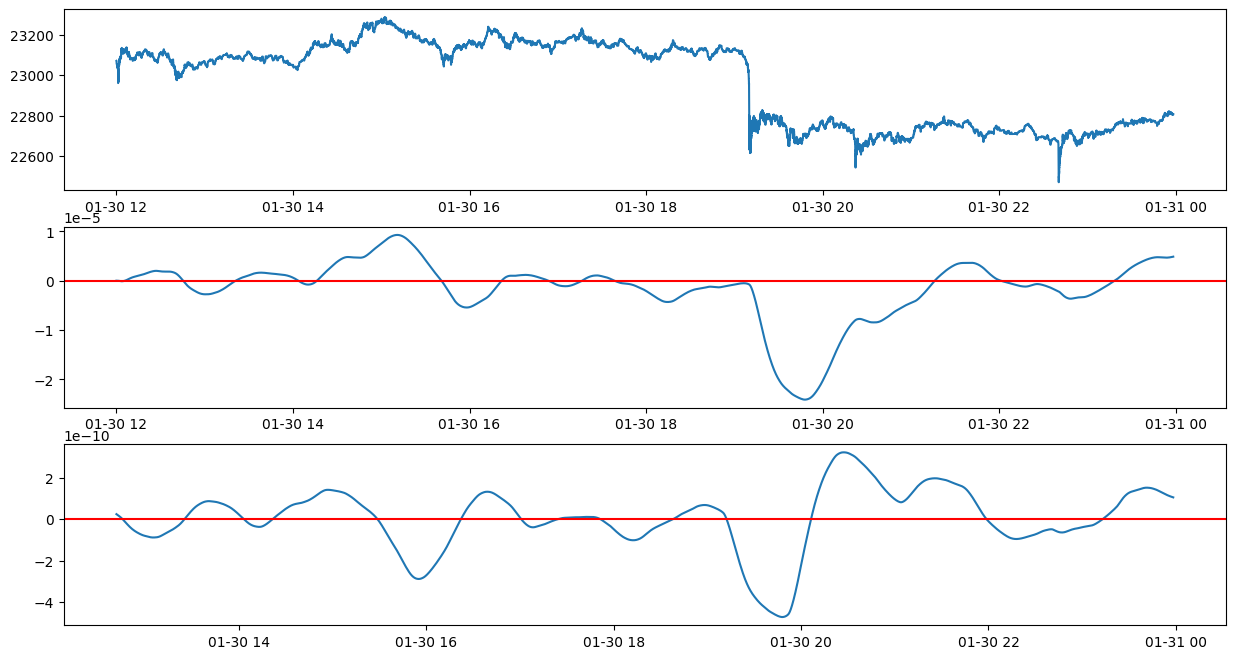

In [255]:
temp = test[:]
plt.figure(figsize=(15,8))
plt.subplot(3,1,1)
plt.plot(temp['B_ask'])
plt.subplot(3,1,2)
plt.plot(temp['TRIX'])
plt.axhline(0, color='r')
plt.subplot(3,1,3)
plt.plot(temp['TRIX_diff'])
plt.axhline(0, color='r')
plt.show()

### train

In [248]:
B_RS, B_RE = 0, 0

th = 1e-20
status = 0
status_ = 0

pnls = []
pnls.append(B_RE)

positions = []

for i, row in train[period:].iterrows():
    p = row['B_mid']
    t = row['TRIX_diff']

    #long
    if t > th and status == 0:
        status = 1
        B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
        position = {
            'i_open':i,
            'side':+1,
            'p_open':row['B_ask']
        }
    elif t < 0 and status == 1:
        status = 0
        B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
        position['i_exit'] = i
        position['p_exit'] = row['B_bid']
        position['p_delta'] = position['p_exit'] - position['p_open']
        position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit']) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
        positions.append(position)
        pnls.append(B_RE)

    #short
    elif t < -th and status == 0:
        status = -1
        B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
        position = {
            'i_open':i,
            'side':-1,
            'p_open':row['B_bid']
        }
    elif t > 0 and status == -1:
        status = 0
        B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
        position['i_exit'] = i
        position['p_exit'] = row['B_ask']
        position['p_delta'] = position['p_exit'] - position['p_open']
        position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit'])*(-1) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
        positions.append(position)
        pnls.append(B_RE)


#close position, if open
if status == 1:
    B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
    position['i_exit'] = i
    position['p_exit'] = row['B_bid']
    position['p_delta'] = position['p_exit'] - position['p_open']
    position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit']) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
    positions.append(position)
if status == -1:
    B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
    position['i_exit'] = i
    position['p_exit'] = row['B_ask']
    position['p_delta'] = position['p_exit'] - position['p_open']
    position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit'])*(-1) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
    positions.append(position)

pnls.append(B_RE)

print(f"{B_RS:.4f} > {B_RE:.4f}")

0.0000 > 0.5889


0.5888924261730766


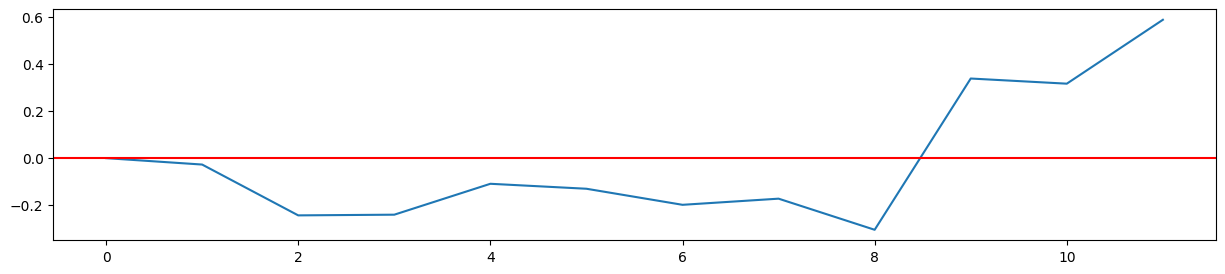

In [249]:
print(pd.DataFrame(positions)['pnl'].sum())
plt.figure(figsize=(15,3))
plt.plot(pnls)
plt.axhline(0, color='r')
plt.show()

### test

In [256]:
B_RS, B_RE = 0, 0

th = 1e-20
status = 0
status_ = 0

pnls = []
pnls.append(B_RE)

positions = []

for i, row in test[period:].iterrows():
    p = row['B_mid']
    t = row['TRIX_diff']

    #long
    if t > th and status == 0:
        status = 1
        B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
        position = {
            'i_open':i,
            'side':+1,
            'p_open':row['B_ask']
        }
    elif t < 0 and status == 1:
        status = 0
        B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
        position['i_exit'] = i
        position['p_exit'] = row['B_bid']
        position['p_delta'] = position['p_exit'] - position['p_open']
        position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit']) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
        positions.append(position)
        pnls.append(B_RE)

    #short
    elif t < -th and status == 0:
        status = -1
        B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
        position = {
            'i_open':i,
            'side':-1,
            'p_open':row['B_bid']
        }
    elif t > 0 and status == -1:
        status = 0
        B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
        position['i_exit'] = i
        position['p_exit'] = row['B_ask']
        position['p_delta'] = position['p_exit'] - position['p_open']
        position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit'])*(-1) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
        positions.append(position)
        pnls.append(B_RE)


#close position, if open
if status == 1:
    B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
    position['i_exit'] = i
    position['p_exit'] = row['B_bid']
    position['p_delta'] = position['p_exit'] - position['p_open']
    position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit']) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
    positions.append(position)
if status == -1:
    B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
    position['i_exit'] = i
    position['p_exit'] = row['B_ask']
    position['p_delta'] = position['p_exit'] - position['p_open']
    position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit'])*(-1) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
    positions.append(position)

pnls.append(B_RE)

print(f"{B_RS:.4f} > {B_RE:.4f}")

0.0000 > -1.2601


-1.2600893177128594


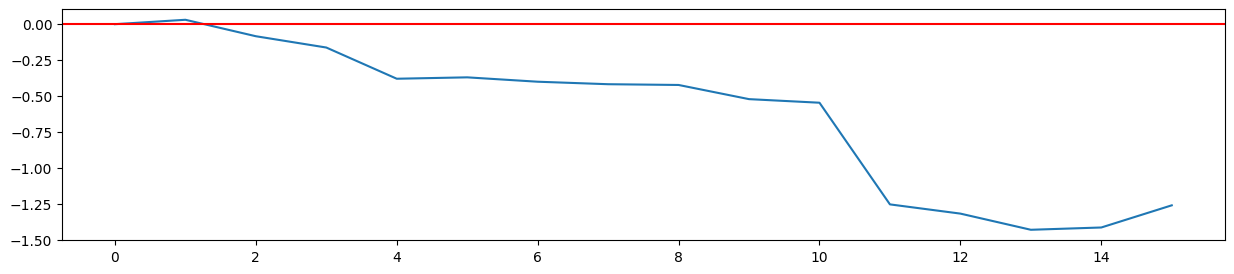

In [257]:
print(pd.DataFrame(positions)['pnl'].sum())
plt.figure(figsize=(15,3))
plt.plot(pnls)
plt.axhline(0, color='r')
plt.show()

# Volume imbalances

In [282]:
df = df0[2000:-2000].copy()
df['B_ask'] = df['B_ob_ask_price_0']
df['B_bid'] = df['B_ob_bid_price_0']

df['B_mid'] = (df['B_ask'] + df['B_bid'])/2

depths = [0, 1, 2, 4, 9]

for N in depths:
    ask_cols_B = [f'B_ob_ask_volume_{i}' for i in range(N+1)]
    bid_cols_B = [f'B_ob_bid_volume_{i}' for i in range(N+1)]
    sum_ask_B = df[ask_cols_B].sum(axis=1)
    sum_bid_B = df[bid_cols_B].sum(axis=1)
    df[f'B_imb_{N}'] = (sum_ask_B - sum_bid_B) / (sum_ask_B + sum_bid_B)
    df[f'B_imb_{N}_diff'] = df[f'B_imb_{N}'].diff()

    ask_cols_D = [f'D_ob_ask_volume_{i}' for i in range(N+1)]
    bid_cols_D = [f'D_ob_bid_volume_{i}' for i in range(N+1)]
    sum_ask_D = df[ask_cols_D].sum(axis=1)
    sum_bid_D = df[bid_cols_D].sum(axis=1)
    df[f'D_imb_{N}'] = (sum_ask_D - sum_bid_D) / (sum_ask_D + sum_bid_D)
    df[f'D_imb_{N}_diff'] = df[f'D_imb_{N}'].diff()

In [343]:
df['B_mid'].mean()*B_fee*2, df['B_mid'].mean()*B_fee_*2

(np.float32(2.3267484), np.float32(8.14362))

To break even after fees, the minimum price movement needs to be around 2.33 points (with low fees) and 8.15 points (with high fees) — assuming a 100% success rate in predicting the direction

Let's choose a step size such that the average absolute price change is greater than that

In [350]:
df['B_delta'] = df['B_mid'].shift(-20*7) - df['B_mid']
df['B_delta'].mean(), df['B_delta'].abs().mean()

(np.float32(-0.0763809), np.float32(2.557446))

In [351]:
train = df[:int(len(df)/2)]
test = df[int(len(df)/2):]

In [352]:
train[['B_delta','B_imb_0','B_imb_1','B_imb_2','B_imb_4','B_imb_9']].corr()

,B_delta,B_imb_0,B_imb_1,B_imb_2,B_imb_4,B_imb_9
B_delta,1.000000,-0.222032,-0.215219,-0.210505,-0.201087,-0.185421
B_imb_0,-0.222032,1.000000,0.952518,0.899153,0.806175,0.666746
B_imb_1,-0.215219,0.952518,1.000000,0.961429,0.863613,0.714156
B_imb_2,-0.210505,0.899153,0.961429,1.000000,0.915682,0.750146
B_imb_4,-0.201087,0.806175,0.863613,0.915682,1.000000,0.823206
B_imb_9,-0.185421,0.666746,0.714156,0.750146,0.823206,1.000000


In [354]:
train[['B_delta','B_imb_0_diff','B_imb_1_diff','B_imb_2_diff','B_imb_4_diff','B_imb_9_diff']].corr()

,B_delta,B_imb_0_diff,B_imb_1_diff,B_imb_2_diff,B_imb_4_diff,B_imb_9_diff
B_delta,1.000000,-0.027632,-0.029836,-0.030459,-0.030755,-0.030865
B_imb_0_diff,-0.027632,1.000000,0.707772,0.545672,0.388307,0.277015
B_imb_1_diff,-0.029836,0.707772,1.000000,0.742471,0.491436,0.338123
B_imb_2_diff,-0.030459,0.545672,0.742471,1.000000,0.609939,0.396359
B_imb_4_diff,-0.030755,0.388307,0.491436,0.609939,1.000000,0.511294
B_imb_9_diff,-0.030865,0.277015,0.338123,0.396359,0.511294,1.000000


In [355]:
train[train['B_imb_9'].between(-0.5,0.5)][['B_delta','B_imb_0','B_imb_1','B_imb_2','B_imb_4','B_imb_9']].corr()

,B_delta,B_imb_0,B_imb_1,B_imb_2,B_imb_4,B_imb_9
B_delta,1.000000,-0.201611,-0.191949,-0.184835,-0.171407,-0.144501
B_imb_0,-0.201611,1.000000,0.945517,0.883719,0.774088,0.595173
B_imb_1,-0.191949,0.945517,1.000000,0.954989,0.838505,0.645886
B_imb_2,-0.184835,0.883719,0.954989,1.000000,0.897597,0.681916
B_imb_4,-0.171407,0.774088,0.838505,0.897597,1.000000,0.765249
B_imb_9,-0.144501,0.595173,0.645886,0.681916,0.765249,1.000000


In [356]:
train[train['B_imb_9'].between(-1.0,-0.2)][['B_delta','B_imb_0','B_imb_1','B_imb_2','B_imb_4','B_imb_9']].corr()

,B_delta,B_imb_0,B_imb_1,B_imb_2,B_imb_4,B_imb_9
B_delta,1.000000,-0.164659,-0.151621,-0.139110,-0.110203,-0.100787
B_imb_0,-0.164659,1.000000,0.916369,0.807974,0.625690,0.420154
B_imb_1,-0.151621,0.916369,1.000000,0.916374,0.715675,0.467052
B_imb_2,-0.139110,0.807974,0.916374,1.000000,0.821281,0.519193
B_imb_4,-0.110203,0.625690,0.715675,0.821281,1.000000,0.606733
B_imb_9,-0.100787,0.420154,0.467052,0.519193,0.606733,1.000000


In [373]:
train[(train['B_imb_9'] < -0.7) & (train['B_imb_0'] < 1)]['B_delta'].mean(), len(train[(train['B_imb_9'] < -0.7) & (train['B_imb_0'] < 1)]['B_delta'])

(np.float32(2.672864), 3693)

In [378]:
train[(train['B_imb_9'] > 0.7) & (train['B_imb_0'] > -1)]['B_delta'].mean(), len(train[(train['B_imb_9'] > 0.7) & (train['B_imb_0'] > -1)]['B_delta'])

(np.float32(-3.2122633), 4079)

In [380]:
(3693 + 4079)/len(train)*100

0.9016241299303944

### train

In [381]:
B_RS, B_RE = 0, 0

th = 0.7
status = 0
status_ = 0

pnls = []
pnls.append(B_RE)

positions = []

for i, row in train[period:].iterrows():
    p = row['B_mid']
    imb = row['B_imb_9']

    #long
    if imb < -th and status == 0:
        status = 1
        B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
        position = {
            'i_open':i,
            'side':+1,
            'p_open':row['B_ask']
        }
    elif imb > 0 and status == 1:
        status = 0
        B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
        position['i_exit'] = i
        position['p_exit'] = row['B_bid']
        position['p_delta'] = position['p_exit'] - position['p_open']
        position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit']) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
        positions.append(position)
        pnls.append(B_RE)

    #short
    elif imb > th and status == 0:
        status = -1
        B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
        position = {
            'i_open':i,
            'side':-1,
            'p_open':row['B_bid']
        }
    elif imb < 0 and status == -1:
        status = 0
        B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
        position['i_exit'] = i
        position['p_exit'] = row['B_ask']
        position['p_delta'] = position['p_exit'] - position['p_open']
        position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit'])*(-1) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
        positions.append(position)
        pnls.append(B_RE)


#close position, if open
if status == 1:
    B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
    position['i_exit'] = i
    position['p_exit'] = row['B_bid']
    position['p_delta'] = position['p_exit'] - position['p_open']
    position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit']) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
    positions.append(position)
if status == -1:
    B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
    position['i_exit'] = i
    position['p_exit'] = row['B_ask']
    position['p_delta'] = position['p_exit'] - position['p_open']
    position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit'])*(-1) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
    positions.append(position)

pnls.append(B_RE)

print(f"{B_RS:.4f} > {B_RE:.4f}")

0.0000 > 1.8479


1.8478787626093347


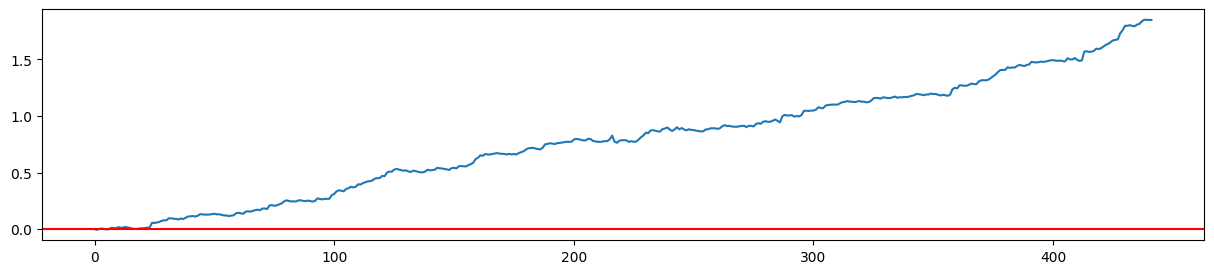

In [382]:
print(pd.DataFrame(positions)['pnl'].sum())
plt.figure(figsize=(15,3))
plt.plot(pnls)
plt.axhline(0, color='r')
plt.show()

### test

In [383]:
B_RS, B_RE = 0, 0

th = 0.7
status = 0
status_ = 0

pnls = []
pnls.append(B_RE)

positions = []

for i, row in test[period:].iterrows():
    p = row['B_mid']
    imb = row['B_imb_9']

    #long
    if imb < -th and status == 0:
        status = 1
        B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
        position = {
            'i_open':i,
            'side':+1,
            'p_open':row['B_ask']
        }
    elif imb > 0 and status == 1:
        status = 0
        B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
        position['i_exit'] = i
        position['p_exit'] = row['B_bid']
        position['p_delta'] = position['p_exit'] - position['p_open']
        position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit']) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
        positions.append(position)
        pnls.append(B_RE)

    #short
    elif imb > th and status == 0:
        status = -1
        B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
        position = {
            'i_open':i,
            'side':-1,
            'p_open':row['B_bid']
        }
    elif imb < 0 and status == -1:
        status = 0
        B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
        position['i_exit'] = i
        position['p_exit'] = row['B_ask']
        position['p_delta'] = position['p_exit'] - position['p_open']
        position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit'])*(-1) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
        positions.append(position)
        pnls.append(B_RE)


#close position, if open
if status == 1:
    B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee)
    position['i_exit'] = i
    position['p_exit'] = row['B_bid']
    position['p_delta'] = position['p_exit'] - position['p_open']
    position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit']) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
    positions.append(position)
if status == -1:
    B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee)
    position['i_exit'] = i
    position['p_exit'] = row['B_ask']
    position['p_delta'] = position['p_exit'] - position['p_open']
    position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit'])*(-1) - MAX_POSITION/position['p_open']*B_fee - MAX_POSITION/position['p_exit']*B_fee
    positions.append(position)

pnls.append(B_RE)

print(f"{B_RS:.4f} > {B_RE:.4f}")

0.0000 > 1.4404


1.4403905861258512


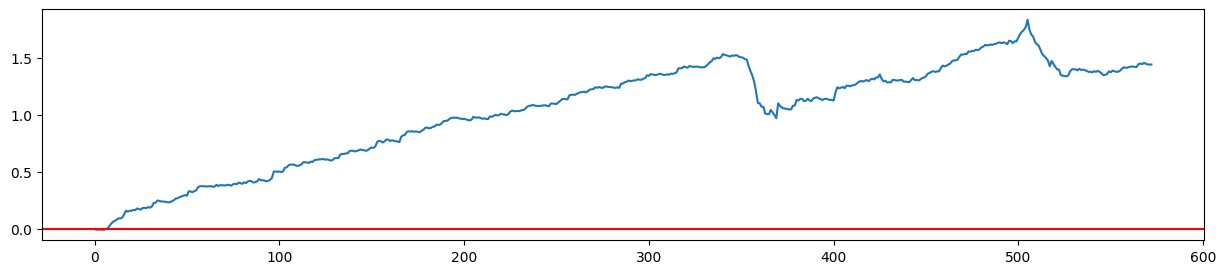

In [384]:
print(pd.DataFrame(positions)['pnl'].sum())
plt.figure(figsize=(15,3))
plt.plot(pnls)
plt.axhline(0, color='r')
plt.show()

### test with large fee

In [388]:
B_RS, B_RE = 0, 0

th = 0.7
status = 0
status_ = 0

pnls = []
pnls.append(B_RE)

positions = []

for i, row in test[period:].iterrows():
    p = row['B_mid']
    imb = row['B_imb_9']

    #long
    if imb < -th and status == 0:
        status = 1
        B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee_)
        position = {
            'i_open':i,
            'side':+1,
            'p_open':row['B_ask']
        }
    elif imb > 0 and status == 1:
        status = 0
        B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee_)
        position['i_exit'] = i
        position['p_exit'] = row['B_bid']
        position['p_delta'] = position['p_exit'] - position['p_open']
        position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit']) - MAX_POSITION/position['p_open']*B_fee_ - MAX_POSITION/position['p_exit']*B_fee_
        positions.append(position)
        pnls.append(B_RE)

    #short
    elif imb > th and status == 0:
        status = -1
        B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee_)
        position = {
            'i_open':i,
            'side':-1,
            'p_open':row['B_bid']
        }
    elif imb < 0 and status == -1:
        status = 0
        B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee_)
        position['i_exit'] = i
        position['p_exit'] = row['B_ask']
        position['p_delta'] = position['p_exit'] - position['p_open']
        position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit'])*(-1) - MAX_POSITION/position['p_open']*B_fee_ - MAX_POSITION/position['p_exit']*B_fee_
        positions.append(position)
        pnls.append(B_RE)


#close position, if open
if status == 1:
    B_RE += calc_r(-1, MAX_POSITION, row['B_bid'], B_fee_)
    position['i_exit'] = i
    position['p_exit'] = row['B_bid']
    position['p_delta'] = position['p_exit'] - position['p_open']
    position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit']) - MAX_POSITION/position['p_open']*B_fee_ - MAX_POSITION/position['p_exit']*B_fee_
    positions.append(position)
if status == -1:
    B_RE += calc_r(+1, MAX_POSITION, row['B_ask'], B_fee_)
    position['i_exit'] = i
    position['p_exit'] = row['B_ask']
    position['p_delta'] = position['p_exit'] - position['p_open']
    position['pnl'] = MAX_POSITION*(1/position['p_open'] - 1/position['p_exit'])*(-1) - MAX_POSITION/position['p_open']*B_fee_ - MAX_POSITION/position['p_exit']*B_fee_
    positions.append(position)

pnls.append(B_RE)

print(f"{B_RS:.4f} > {B_RE:.4f}")

0.0000 > -4.7847


-4.78473729304767


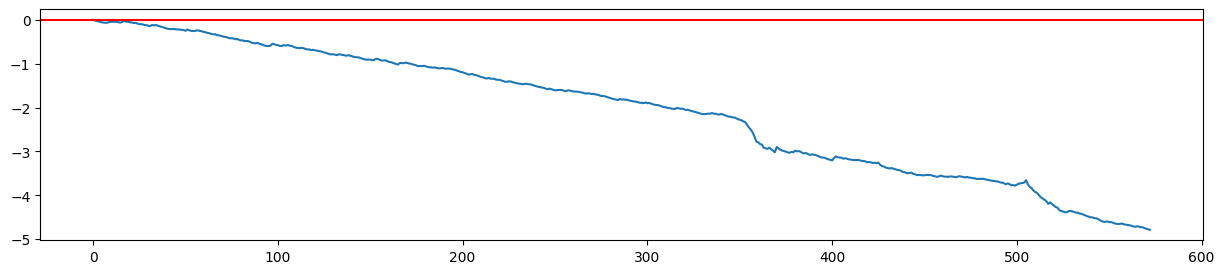

In [389]:
print(pd.DataFrame(positions)['pnl'].sum())
plt.figure(figsize=(15,3))
plt.plot(pnls)
plt.axhline(0, color='r')
plt.show()

This can only work with ultra-low fees.
Alternatively, the algorithm could be improved by predicting the probability that a limit order (post-only) at a certain price will be filled within a few ticks

# Volume imbalance (rolling)

In [390]:
df = df0[2000:-2000].copy()
df['B_ask'] = df['B_ob_ask_price_0']
df['B_bid'] = df['B_ob_bid_price_0']

df['B_mid'] = (df['B_ask'] + df['B_bid'])/2

depths = [0, 1, 2, 4, 9]

for N in depths:
    ask_cols_B = [f'B_ob_ask_volume_{i}' for i in range(N+1)]
    bid_cols_B = [f'B_ob_bid_volume_{i}' for i in range(N+1)]
    sum_ask_B = df[ask_cols_B].sum(axis=1)
    sum_bid_B = df[bid_cols_B].sum(axis=1)
    df[f'B_imb_{N}'] = (sum_ask_B - sum_bid_B) / (sum_ask_B + sum_bid_B)
    df[f'B_imb_{N}_rs'] = df[f'B_imb_{N}'].rolling('1min').mean()
    df[f'B_imb_{N}_diff'] = df[f'B_imb_{N}'].diff()

    ask_cols_D = [f'D_ob_ask_volume_{i}' for i in range(N+1)]
    bid_cols_D = [f'D_ob_bid_volume_{i}' for i in range(N+1)]
    sum_ask_D = df[ask_cols_D].sum(axis=1)
    sum_bid_D = df[bid_cols_D].sum(axis=1)
    df[f'D_imb_{N}'] = (sum_ask_D - sum_bid_D) / (sum_ask_D + sum_bid_D)
    df[f'D_imb_{N}_rs'] = df[f'D_imb_{N}'].rolling('1min').mean()
    df[f'D_imb_{N}_diff'] = df[f'D_imb_{N}'].diff()

In [398]:
df['B_delta'] = df['B_mid'].shift(-20*60) - df['B_mid']
df['B_delta'].mean(), df['B_delta'].abs().mean()

(np.float32(-0.65172374), np.float32(10.303467))

In [399]:
train = df[:int(len(df)/2)]
test = df[int(len(df)/2):]

In [400]:
train[['B_delta','B_imb_0_rs','B_imb_1_rs','B_imb_2_rs','B_imb_4_rs','B_imb_9_rs']].corr()

,B_delta,B_imb_0_rs,B_imb_1_rs,B_imb_2_rs,B_imb_4_rs,B_imb_9_rs
B_delta,1.000000,-0.000579,-0.001737,-0.005659,-0.006676,-0.003680
B_imb_0_rs,-0.000579,1.000000,0.966035,0.912160,0.793373,0.601745
B_imb_1_rs,-0.001737,0.966035,1.000000,0.972782,0.870646,0.687197
B_imb_2_rs,-0.005659,0.912160,0.972782,1.000000,0.935023,0.753332
B_imb_4_rs,-0.006676,0.793373,0.870646,0.935023,1.000000,0.863225
B_imb_9_rs,-0.003680,0.601745,0.687197,0.753332,0.863225,1.000000


In [401]:
train[(train['B_imb_9_rs'] < -0.55)]['B_delta'].mean(), len(train[(train['B_imb_9_rs'] < -0.55)]['B_delta'])

(np.float32(-3.4472818), 2532)

In [403]:
train[(train['B_imb_9_rs'] > 0.55)]['B_delta'].mean(), len(train[(train['B_imb_9_rs'] > 0.55)]['B_delta'])

(np.float32(-2.840654), 393)

In [406]:
ME = (2532*(3.44 - 2.33) - 393*(2.84 + 2.33))/(2532 + 393)
ME

0.2662256410256409

In theory, it’s also possible to get a positive result — but with high fees, it will definitely be negative

# Peaks

In [407]:
df = df0[2000:-2000].copy()
df['B_ask'] = df['B_ob_ask_price_0']
df['B_bid'] = df['B_ob_bid_price_0']
df['B_mid'] = (df['B_ask'] + df['B_bid'])/2

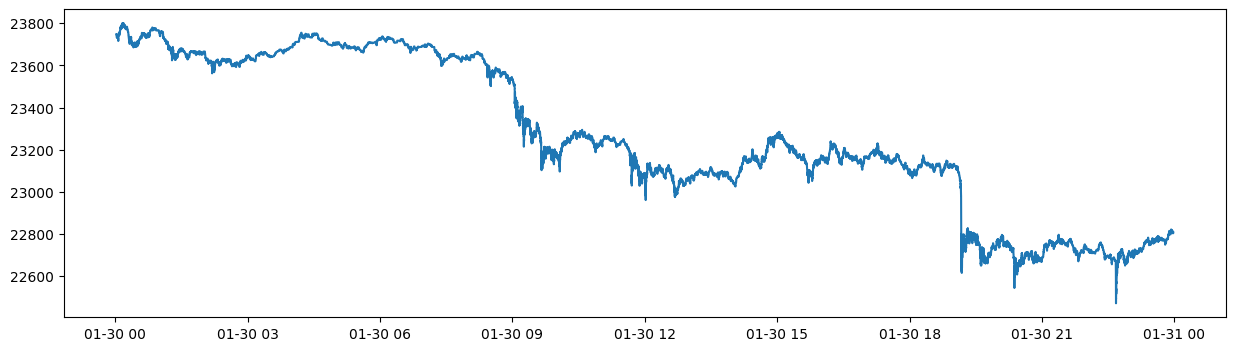

In [408]:
plt.figure(figsize=(15,4))
plt.plot(df['B_ask'])
plt.show()

In [409]:
def detect_directional_changes(prices, T1, T2):
    state = "up"
    high = prices[0]
    low = prices[0]
    high_idx = low_idx = 0

    events = {"down": [], "up": []}

    for t, p in enumerate(prices[1:], start=1):
        if state == "up":
            if p > high:
                high, high_idx = p, t
            elif p < high * (1 - T1):
                events["down"].append((high_idx, high))
                state = "down"
                low, low_idx = p, t

        else:
            if p < low:
                low, low_idx = p, t
            elif p > low * (1 + T2):
                events["up"].append((low_idx, low))
                state = "up"
                high, high_idx = p, t

    last_candidate = (low_idx, low) if state == "down" else None

    return events, last_candidate

In [433]:
prices = df['B_mid'].values
events, last_valley = detect_directional_changes(prices, T1=0.1/100, T2=0.1/100)

In [434]:
points_down = [x[0] for x in events['down']]
points_up = [x[0] for x in events['up']]

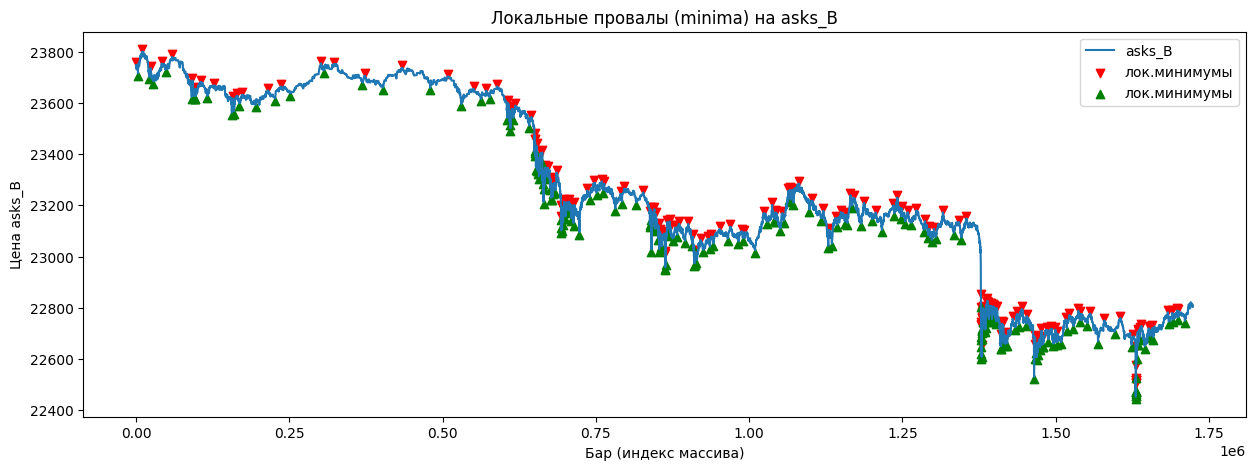

In [435]:
plt.figure(figsize=(15,5))
plt.plot(prices, label='asks_B')
plt.scatter(points_down, prices[points_down] + 10, marker='v', label='лок.минимумы', color='red')
plt.scatter(points_up, prices[points_up] - 10, marker='^', label='лок.минимумы', color='green')
plt.legend()
plt.xlabel('Бар (индекс массива)')
plt.ylabel('Цена asks_B')
plt.title('Локальные провалы (minima) на asks_B')
plt.show()

In [441]:
peaks = np.array(points_down, dtype=int)

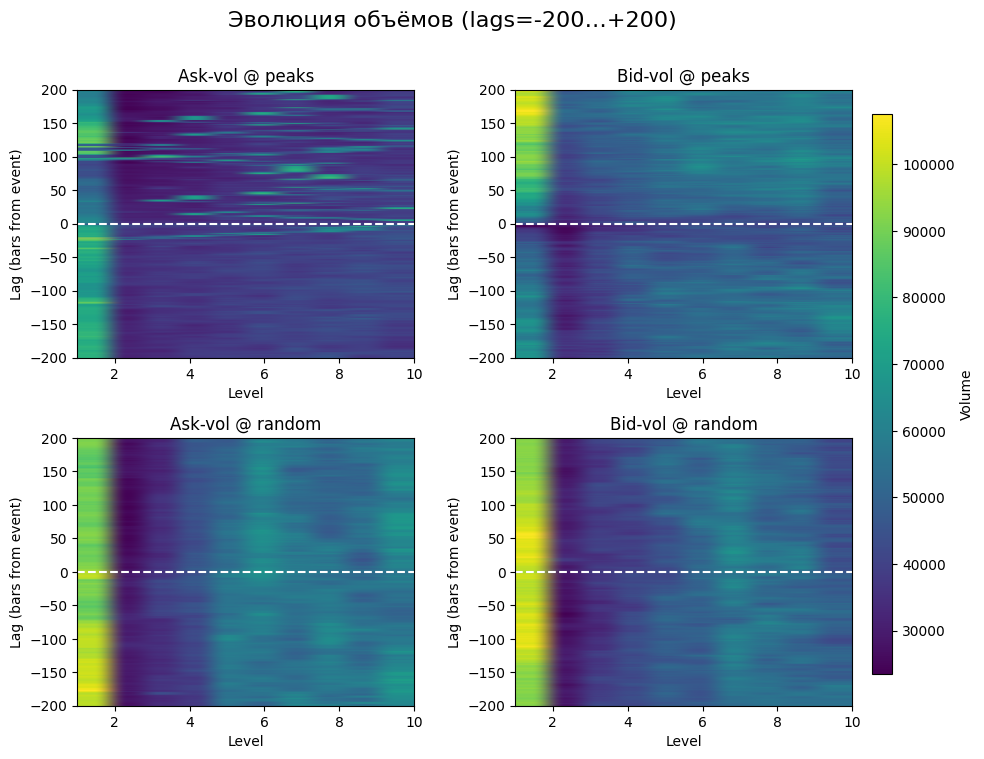

In [445]:
n_back = 20*10
n_forw = 20*10

n_levels = 10
ask_cols = [f"B_ob_ask_volume_{i}" for i in range(n_levels)]
bid_cols = [f"B_ob_bid_volume_{i}" for i in range(n_levels)]

T = len(df)

valid_peaks = peaks[(peaks >= n_back) & (peaks <= T - n_forw - 1)]
n_events = len(valid_peaks)

mask = np.ones(T, dtype=bool)
mask[valid_peaks] = False
candidates = np.where(
    mask &
    (np.arange(T) >= n_back) &
    (np.arange(T) <= T - n_forw - 1)
)[0]
rand_idx = np.random.choice(candidates, size=n_events, replace=False)

def build_cube(idxs, cols):
    return np.stack([
        df.iloc[i - n_back : i + n_forw + 1][cols].values
        for i in idxs
    ], axis=0)

cube_asks_peaks = build_cube(valid_peaks, ask_cols)
cube_bids_peaks = build_cube(valid_peaks, bid_cols)
cube_asks_rand  = build_cube(rand_idx, ask_cols)
cube_bids_rand  = build_cube(rand_idx, bid_cols)

avg_asks_peaks = cube_asks_peaks.mean(axis=0)
avg_bids_peaks = cube_bids_peaks.mean(axis=0)
avg_asks_rand  = cube_asks_rand.mean(axis=0)
avg_bids_rand  = cube_bids_rand.mean(axis=0)

lags   = np.arange(-n_back, n_forw + 1)
levels = np.arange(1, n_levels + 1)

fig, axes = plt.subplots(
    2, 2, figsize=(10, 8),
    gridspec_kw={'wspace':0.3, 'hspace':0.3}
)

def plot_heat(ax, data, title):
    im = ax.imshow(
        data,
        aspect='auto',
        origin='lower',
        extent=[1, n_levels, -n_back, n_forw]
    )
    ax.axhline(0, color='white', linestyle='--', linewidth=1.5)
    ax.set_title(title)
    ax.set_xlabel('Level')
    ax.set_ylabel('Lag (bars from event)')
    return im

im00 = plot_heat(axes[0,0], avg_asks_peaks, 'Ask-vol @ peaks')
im01 = plot_heat(axes[0,1], avg_bids_peaks, 'Bid-vol @ peaks')
im10 = plot_heat(axes[1,0], avg_asks_rand,  'Ask-vol @ random')
im11 = plot_heat(axes[1,1], avg_bids_rand,  'Bid-vol @ random')

cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im11, cax=cax, label='Volume')

plt.suptitle(f'Эволюция объёмов (lags={-n_back}…+{n_forw})', fontsize=16)
plt.show()

In [443]:
peaks = np.array(points_up, dtype=int)

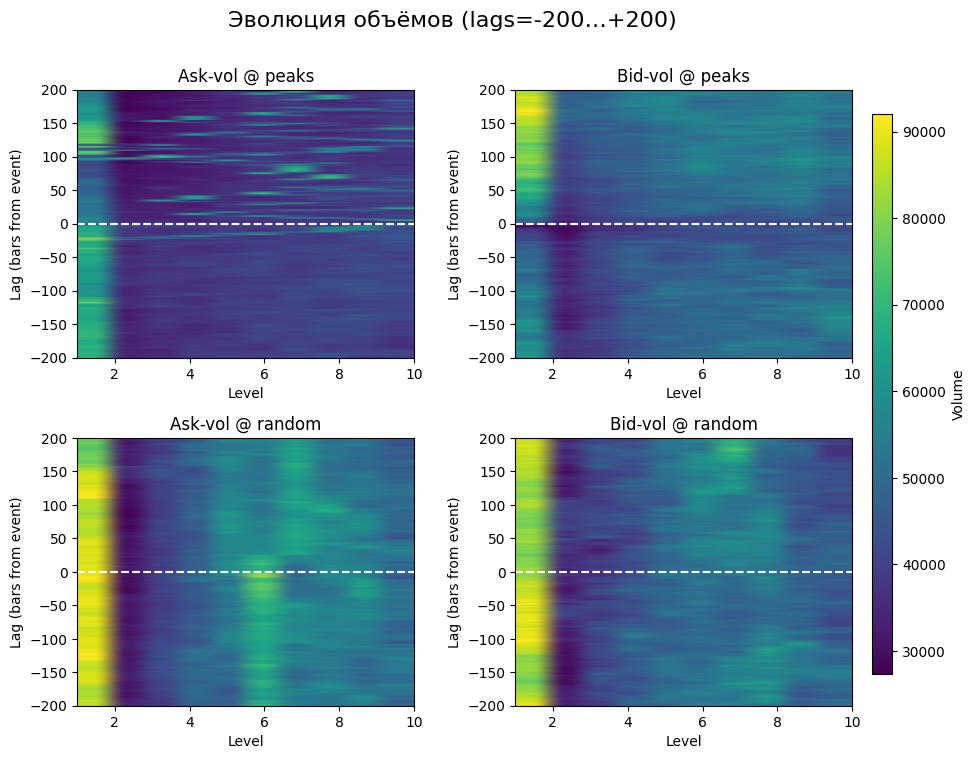

In [446]:
n_back = 20*10
n_forw = 20*10

n_levels = 10
ask_cols = [f"B_ob_ask_volume_{i}" for i in range(n_levels)]
bid_cols = [f"B_ob_bid_volume_{i}" for i in range(n_levels)]

T = len(df)

valid_peaks = peaks[(peaks >= n_back) & (peaks <= T - n_forw - 1)]
n_events = len(valid_peaks)

mask = np.ones(T, dtype=bool)
mask[valid_peaks] = False
candidates = np.where(
    mask &
    (np.arange(T) >= n_back) &
    (np.arange(T) <= T - n_forw - 1)
)[0]
rand_idx = np.random.choice(candidates, size=n_events, replace=False)

def build_cube(idxs, cols):
    return np.stack([
        df.iloc[i - n_back : i + n_forw + 1][cols].values
        for i in idxs
    ], axis=0)

cube_asks_peaks = build_cube(valid_peaks, ask_cols)
cube_bids_peaks = build_cube(valid_peaks, bid_cols)
cube_asks_rand  = build_cube(rand_idx, ask_cols)
cube_bids_rand  = build_cube(rand_idx, bid_cols)

avg_asks_peaks = cube_asks_peaks.mean(axis=0)
avg_bids_peaks = cube_bids_peaks.mean(axis=0)
avg_asks_rand  = cube_asks_rand.mean(axis=0)
avg_bids_rand  = cube_bids_rand.mean(axis=0)

lags   = np.arange(-n_back, n_forw + 1)
levels = np.arange(1, n_levels + 1)

fig, axes = plt.subplots(
    2, 2, figsize=(10, 8),
    gridspec_kw={'wspace':0.3, 'hspace':0.3}
)

def plot_heat(ax, data, title):
    im = ax.imshow(
        data,
        aspect='auto',
        origin='lower',
        extent=[1, n_levels, -n_back, n_forw]
    )
    ax.axhline(0, color='white', linestyle='--', linewidth=1.5)
    ax.set_title(title)
    ax.set_xlabel('Level')
    ax.set_ylabel('Lag (bars from event)')
    return im

im00 = plot_heat(axes[0,0], avg_asks_peaks, 'Ask-vol @ peaks')
im01 = plot_heat(axes[0,1], avg_bids_peaks, 'Bid-vol @ peaks')
im10 = plot_heat(axes[1,0], avg_asks_rand,  'Ask-vol @ random')
im11 = plot_heat(axes[1,1], avg_bids_rand,  'Bid-vol @ random')

cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im11, cax=cax, label='Volume')

plt.suptitle(f'Эволюция объёмов (lags={-n_back}…+{n_forw})', fontsize=16)
plt.show()

On both charts, we can see that a few seconds before a peak (both upward and downward), the volume on one side starts to drop, and right at or after the turning point, the situation shifts

In theory, we could try training an algorithm to classify the data in a way that allows it to predict changes in advance - or detect them right at the turning point.

It’s a very interesting task, but one day of data is nowhere near enough to properly train and test such an algorithm

# Arbitrage

In [473]:
df = df0[2000:-2000].copy()
df['B_mid'] = (df['B_ob_ask_price_0'] + df['B_ob_bid_price_0'])/2
df['D_mid'] = (df['D_ob_ask_price_0'] + df['D_ob_bid_price_0'])/2

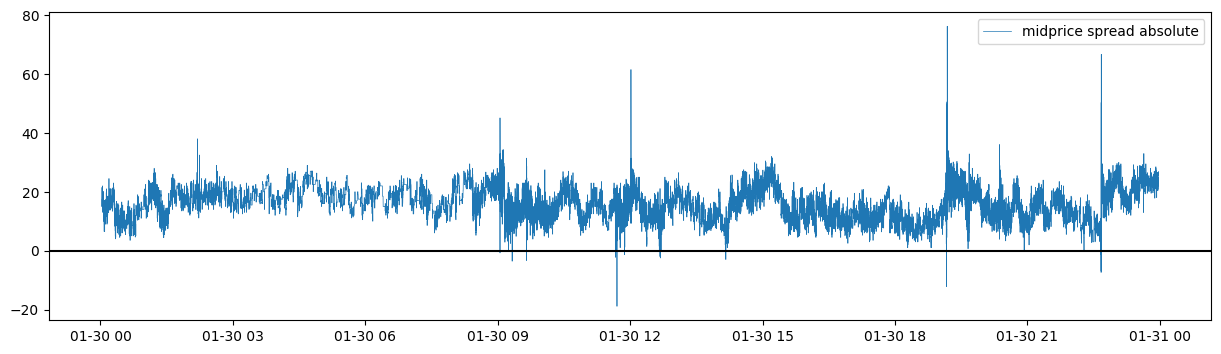

In [476]:
plt.figure(figsize=(15,4))
plt.plot(df['D_mid'] - df['B_mid'], linewidth=0.5, label='midprice spread absolute')
plt.axhline(0, color='k')
plt.legend(loc='best')
plt.show()

Make average

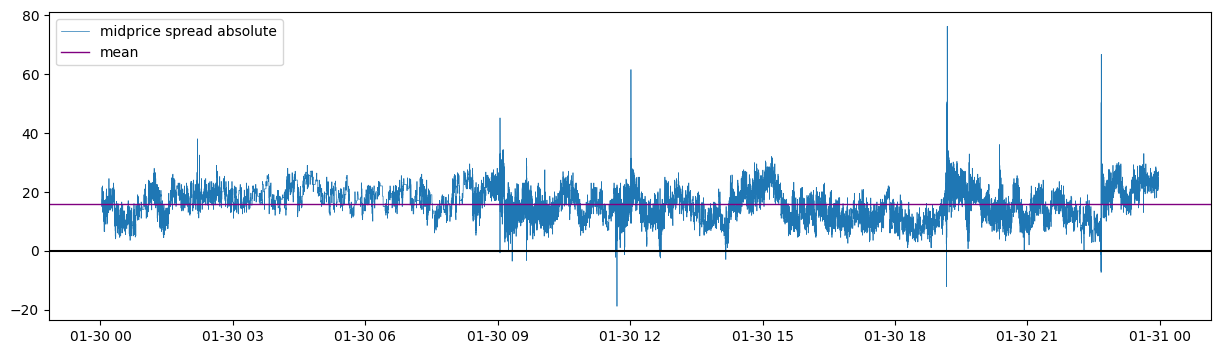

In [482]:
plt.figure(figsize=(15,4))
plt.plot(df['D_mid'] - df['B_mid'], linewidth=0.5, label='midprice spread absolute')
plt.axhline((df['D_mid'] - df['B_mid']).mean(), color='purple', linewidth=1, label='mean')
plt.axhline(0, color='k')
plt.legend(loc='best')
plt.show()

Add lines of costs

In [490]:
mid = (df['D_mid'] + df['B_mid'])/2
mid_mean = (df['D_mid'] - df['B_mid']).mean()

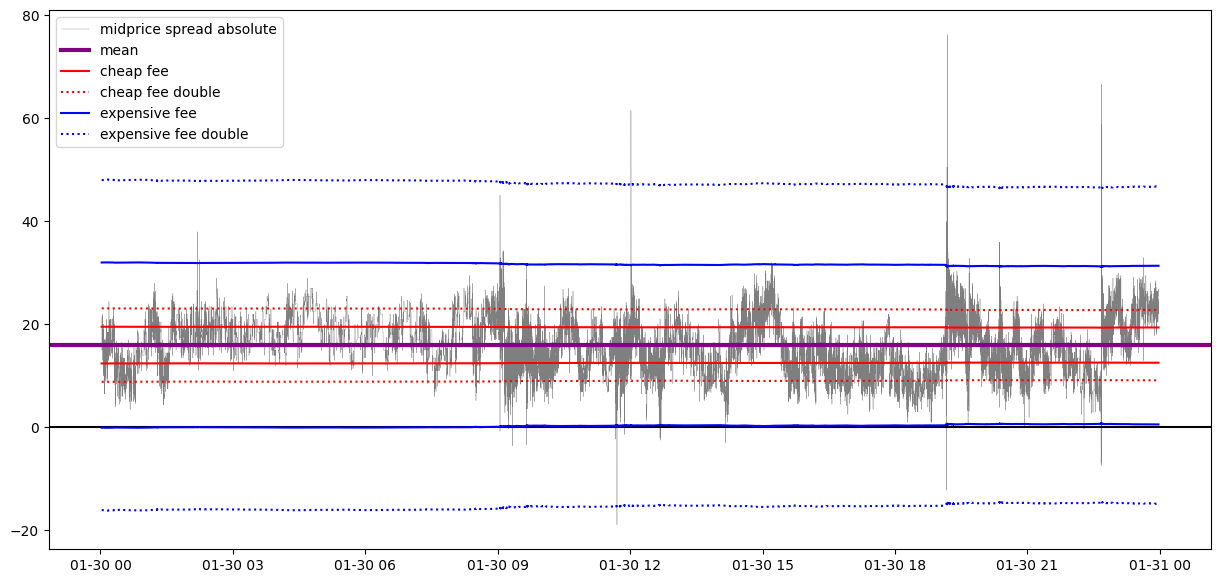

In [493]:
plt.figure(figsize=(15,7))
plt.plot(df['D_mid'] - df['B_mid'], linewidth=0.25, label='midprice spread absolute', alpha=0.5, color='black')
plt.axhline(mid_mean, color='purple', linewidth=3, label='mean')
plt.axhline(0, color='k')


plt.plot((D_fee + B_fee)*mid + mid_mean, color='r', label='cheap fee')
plt.plot(-(D_fee + B_fee)*mid + mid_mean, color='r')
plt.plot(2*(D_fee + B_fee)*mid + mid_mean, color='r', linestyle='dotted', label='cheap fee double')
plt.plot(-2*(D_fee + B_fee)*mid + mid_mean, color='r', linestyle='dotted')

plt.plot((D_fee_ + B_fee_)*mid + mid_mean, color='blue', label='expensive fee')
plt.plot(-(D_fee_ + B_fee_)*mid + mid_mean, color='blue')
plt.plot(2*(D_fee_ + B_fee_)*mid + mid_mean, color='blue', linestyle='dotted', label='expensive fee double')
plt.plot(-2*(D_fee_ + B_fee_)*mid + mid_mean, color='blue', linestyle='dotted')

plt.legend(loc='best')
plt.show()

There’s a strategy where we open and close a position expecting the spread to return to its average.

Of course, in real life we don’t know the true average in advance, so in the simulation we’ll use some form of smoothing instead.

# Conclusion

Results of the tested strategies:

**Buy at the beginning / Sell at the end (long and short):**

-3.6920 and +3.6621 over the full time period.

----

**single SMA.**

+1.6991, +2.7970, -4.0640, - train (small fee), test (small fee), test (large fee)

----

**double EWM**

+0.8550, -0.8201, NAN, - train (small fee), test (small fee), test (large fee)

----

**double KAMA**

+1.3252, +0.2933, NAN, - train (small fee), test (small fee), test (large fee)

----

**TRIX-momentum**

+1.8479, 1.4404, -4.7847, - train (small fee), test (small fee), test (large fee)

----

**Volume imbalance**

+1.8479, +1.4404, -4.7847, - train (small fee), test (small fee), test (large fee)

After testing the most basic strategies, we can conclude that, based on the available data, the only somewhat predictable approach we can implement is a temporal arbitrage algorithm.

In the notebook 03_NW_EDA.ipynb, we'll take a closer look at the spread behavior and the data.